In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch import autograd
import torch.distributions as dist

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from tqdm import tqdm

from rebar import g, g_tilde, g_lmbda, H, sigma, log_likelihood_bern

import torch
import torch.nn as nn
import torch.distributions as dist
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

sns.set_style("whitegrid")

In [2]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

<Axes: ylabel='Count'>

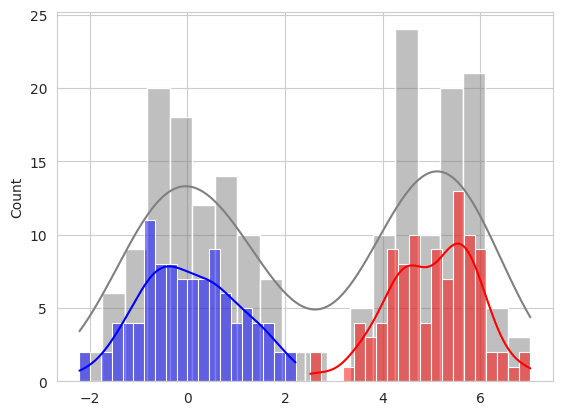

In [3]:
Xs = torch.concatenate([
    torch.randn(100),
    torch.randn(100) + 5,
]).reshape(-1, 1)

sns.histplot(Xs[:, 0], bins=20, kde=True, color='gray', alpha=0.5)
sns.histplot(Xs[:100, 0], bins=20, kde=True, color='blue', alpha=0.5)
sns.histplot(Xs[100:, 0], bins=20, kde=True, color='red', alpha=0.5)

In [4]:
class GMM(nn.Module):
    def __init__(self):
        super().__init__()
        # self.mu = nn.Parameter(torch.tensor([1.0, 3.5]))
        # self.log_sigma = nn.Parameter(torch.zeros(2))
        self.mu = nn.Parameter(torch.randn(2))
        self.log_sigma = nn.Parameter(torch.randn(2))

        # decide - priors fixed or not
        self.logits = nn.Parameter(torch.zeros(2))
        # self.register_buffer('logits', torch.tensor([0.0, 0.0]))
    
    def get_component_probs(self, x):
        dist0 = dist.Normal(self.mu[0], self.log_sigma[0].exp())
        dist1 = dist.Normal(self.mu[1], self.log_sigma[1].exp())
        
        log_probs = torch.stack([
            dist0.log_prob(x.squeeze()),
            dist1.log_prob(x.squeeze())
        ], dim=1)
        
        log_probs += torch.log_softmax(self.logits, dim=0)
        return log_probs
    
    def forward(self, x):
        log_probs = self.get_component_probs(x)
        log_prob = torch.logsumexp(log_probs, dim=1)
        return -log_prob.mean()

    def classify(self, x):
        log_probs = self.get_component_probs(x)
        return torch.softmax(log_probs, dim=1)

In [5]:
def create_objective(model):
    def objective(b):
        mu0, mu1 = model.mu[0], model.mu[1]
        sigma0 = model.log_sigma[0].exp()
        sigma1 = model.log_sigma[1].exp()
        
        dist0 = dist.Normal(mu0, sigma0)
        dist1 = dist.Normal(mu1, sigma1)
        
        log_p0 = dist0.log_prob(Xs.squeeze())
        log_p1 = dist1.log_prob(Xs.squeeze())
        
        selected_log_probs = torch.where(b > 0.5, log_p1, log_p0)
        
        return -selected_log_probs.mean()
    
    return objective

# REINFORCE

In [6]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

100%|██████████| 5000/5000 [00:13<00:00, 377.36it/s]


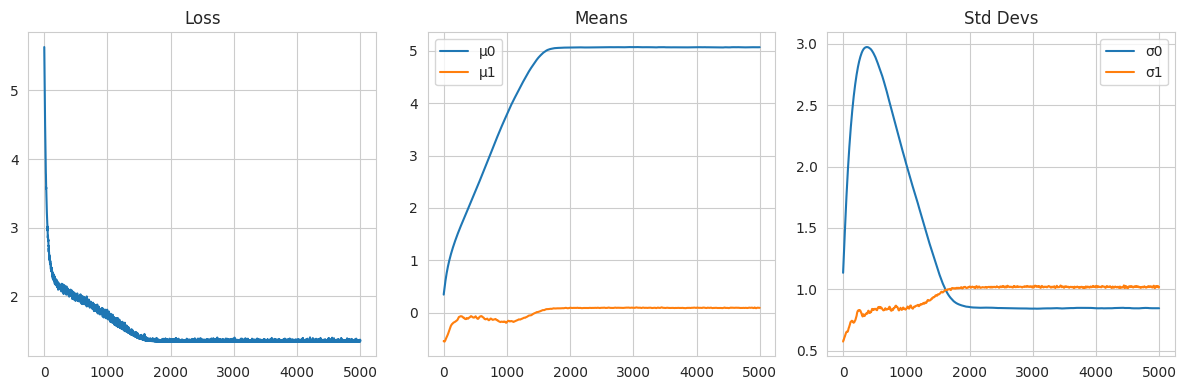

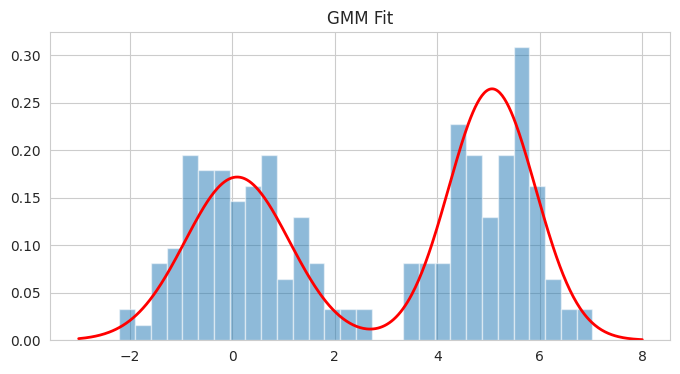

In [10]:
n_epochs = 1000
losses = []
means = []
stds = []

model = GMM()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.99999))

f = create_objective(model)

n_epochs = 5000
losses = []
means = []
stds = []

for epoch in tqdm(range(n_epochs)):
    optimizer.zero_grad()
    
    thetas = model.classify(Xs)
    
    b = torch.bernoulli(thetas[:, 1]).to(torch.int32)
    
    loss = f(b.float()).mean()
    action_log_probs = torch.log(thetas[torch.arange(len(Xs)), b] + 1e-8)
    reinforce_loss = (loss.detach() * action_log_probs).mean()
    
    total_loss = loss + reinforce_loss
    gradients = torch.autograd.grad(total_loss, model.parameters(), retain_graph=False)
    
    for param, grad in zip(model.parameters(), gradients):
        if grad is not None:
            param.grad = grad
    
    optimizer.step()
    
    losses.append(loss.item())
    means.append(model.mu.detach().numpy().copy())
    stds.append(model.log_sigma.exp().detach().numpy().copy())

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(losses)
plt.title("Loss")

plt.subplot(1, 3, 2)
plt.plot(np.array(means)[:, 0], label="μ0")
plt.plot(np.array(means)[:, 1], label="μ1")
plt.title("Means")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(np.array(stds)[:, 0], label="σ0")
plt.plot(np.array(stds)[:, 1], label="σ1")
plt.title("Std Devs")
plt.legend()
plt.tight_layout()
plt.show()

x = torch.linspace(-3, 8, 500)
with torch.no_grad():
    dist0 = dist.Normal(model.mu[0], model.log_sigma[0].exp())
    dist1 = dist.Normal(model.mu[1], model.log_sigma[1].exp())
    mix_probs = torch.softmax(model.logits, dim=0)
    
    y = (mix_probs[0] * torch.exp(dist0.log_prob(x)) + 
         mix_probs[1] * torch.exp(dist1.log_prob(x)))

plt.figure(figsize=(8, 4))
plt.hist(Xs.numpy(), bins=30, density=True, alpha=0.5)
plt.plot(x.numpy(), y.numpy(), 'r-', lw=2)
plt.title("GMM Fit")
plt.show()

# REBAR

In [8]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

100%|██████████| 5000/5000 [00:38<00:00, 129.40it/s]


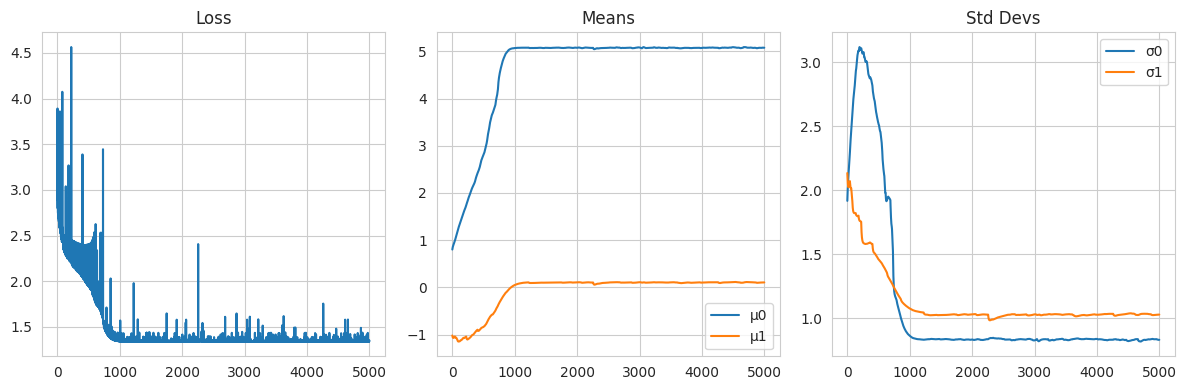

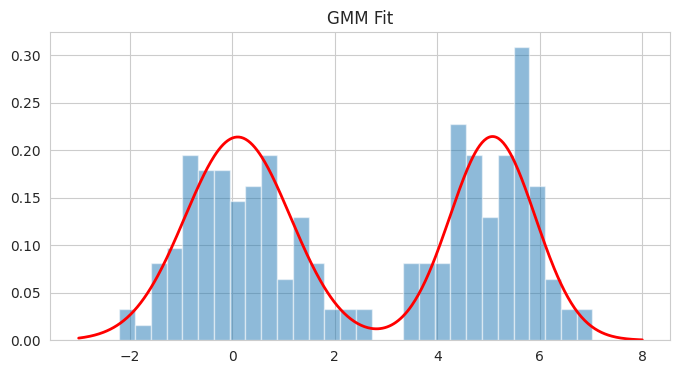

In [11]:
n_epochs = 1000
losses = []
means = []
stds = []

lmbda = torch.tensor([0.1], requires_grad=True)
eta = torch.tensor([-0.1], requires_grad=True)

model = GMM()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.99999))
optimizer_2 = torch.optim.Adam([eta, lmbda], lr=0.01, betas=(0.9, 0.99999))

f = create_objective(model)

n_epochs = 5000
losses = []
means = []
stds = []

for epoch in tqdm(range(n_epochs)):
    optimizer.zero_grad()
    optimizer_2.zero_grad()
    
    thetas = model.classify(Xs)
    
    u = torch.rand(1, 1) + 1e-9
    v = torch.rand(1, 1) + 1e-9
    z = g(u, thetas[:, 1])
    b = H(z).detach()
    z_tilde = g_lmbda(v, thetas[:, 1], lmbda)
    # b = torch.bernoulli(thetas[:, 1]).to(torch.int32)

    first_term = (f(b) - eta * f(sigma(z_tilde.detach(), lmbda))) * log_likelihood_bern(b, thetas[:, 1])
    second_term = eta * f(sigma(z, lmbda))
    third_term = -eta * f(sigma(z_tilde, lmbda))
    rebar_before_grad = first_term + second_term + third_term
    
    loss = f(b.float()).mean()
    
    total_loss = loss + rebar_before_grad.mean()
    gradients = torch.autograd.grad(total_loss, model.parameters(), retain_graph=False)
    
    for param, grad in zip(model.parameters(), gradients):
        if grad is not None:
            param.grad = grad
    
    optimizer.step()
    optimizer_2.step()
    
    losses.append(loss.item())
    means.append(model.mu.detach().numpy().copy())
    stds.append(model.log_sigma.exp().detach().numpy().copy())

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(losses)
plt.title("Loss")

plt.subplot(1, 3, 2)
plt.plot(np.array(means)[:, 0], label="μ0")
plt.plot(np.array(means)[:, 1], label="μ1")
plt.title("Means")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(np.array(stds)[:, 0], label="σ0")
plt.plot(np.array(stds)[:, 1], label="σ1")
plt.title("Std Devs")
plt.legend()
plt.tight_layout()
plt.show()

x = torch.linspace(-3, 8, 500)
with torch.no_grad():
    dist0 = dist.Normal(model.mu[0], model.log_sigma[0].exp())
    dist1 = dist.Normal(model.mu[1], model.log_sigma[1].exp())
    mix_probs = torch.softmax(model.logits, dim=0)
    
    y = (mix_probs[0] * torch.exp(dist0.log_prob(x)) + 
         mix_probs[1] * torch.exp(dist1.log_prob(x)))

plt.figure(figsize=(8, 4))
plt.hist(Xs.numpy(), bins=30, density=True, alpha=0.5)
plt.plot(x.numpy(), y.numpy(), 'r-', lw=2)
plt.title("GMM Fit")
plt.show()